## Understanding PEDAP Dataset
This notebook tries provides details on the structure of the PEDAP dataset and makes suggestions how to process the data.

## The PEDAP study

**Title**: The Pediatric Artificial Pancreas (PEDAP) trial: A Randomized Controlled Comparison of the Control- IQ technology 
Versus Standard of Care in Young Children in Type 1 Diabetes


**Description**: The objective of the study is to assess efficacy, quality of life, and safety of a closed loop control (CLC) system (t:slim X2 with Control-IQ Technology) in a randomized controlled trial with partial crossover.
    
**Devices**: t:slim X2 with Control-IQ and Dexcom G6 system

**Study Population**: Children aged 2 - 5 years old

<div class="alert alert-block alert-danger">
<b>Patient IDs:</b> The patient ids are in a different format across the files. As of now, we cannot use this data. In the Bolus data and patinet roster the PtID is in a 'PEDAP-###-###' format. This id is used by Jaeb to denote StudyName-StudySite-PatientID. In the basal data and cgm data the PtID is an integer. We do not know the conversion from PEDAP-###-### to the PtID integer and cannot confidently combine the basal and CGM data to the correct Bolus data
</div>

# Data
The study data folder is named **PEDAP Public Dataset - Release 1 - 2024-04-16**

From the DataGlossary.rtf file, the following relevant files were identified which are stored in the **Data Files** subfolder.

* **PEDAPTandemBOLUSDELIVERED.txt**: Event logged on pump when delivery of an insulin bolus (Standard, Extended, or Automatic) is completed
* **PEDAPTandemBASALRATECHG.txt**: Event logged on pump when insulin basal rate changes due to pumping events
* **PEDAPTandemCGMDataGXB.txt**: List of cgm data dowloaded 
* **PtRoster.txt**: Patient Roster

These are csv files ("|" separator) and host many columns related to the Tandem pump events and the Dexcom cgm. The glossary provides information about each column. Each file contains a limited amount of columns compared to the FLAIR data. Below are **all** of the columns contained in each file

## PEDAPTandemBOLUSDELIVERED
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time of completion of bolus delivery
* **BolusAmount**: size of completed bolus
* **CarbAmount**: grams of carbs announced to the pump
* **BolusType**: The bolus insulin delivery type [Standard, Extended, Automatic]
* **Duration**: For extended boluses, the requested bolus duration in minutes
* **ExtendedBolusPortion**: Flag distinguishing the immediate (Now) portion of the bolus (if any) from the extended (Later) portion [Now, Later]
## PEDAPTandemBASALRATECHG
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time of basal rate change
* **BasalRate**: Basal Rate (U/h) - The active basal insulin delivery rate in units per hour
## PEDAPTandemCGMDataGXB
* **PtID**: Patient ID
* **DeviceDtTm**: Date-time 
* **CGMValue**: Value of CGM reading, in mg/dL; 0 indicates a below-range reading (<40) or above-range reading (>400)
* **HighLowIndicator**: Flag indicating presence of an in-range reading (0), below-range reading (2), or above-range reading (1)

## Questions


In [1]:
import os, sys, time, random
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

## Load the data

In [3]:
filepath_data = '/Users/rachelbrandt/egvinsulin/data/raw/PEDAP Public Dataset - Release 1 - 2024-04-16/Data Files'
df_bolus = pd.read_csv(os.path.join(filepath_data, 'PEDAPTandemBOLUSDELIVERED.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'BolusAmount', 'BolusType','CarbAmount','Duration','ExtendedBolusPortion'])
df_basal = pd.read_csv(os.path.join(filepath_data, 'PEDAPTandemBASALRATECHG.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'BasalRate'])
df_cgm = pd.read_csv(os.path.join(filepath_data, 'PEDAPTandemCGMDataGXB.txt'), sep="|", low_memory=False,
                         usecols=['RecID', 'PtID', 'DeviceDtTm', 'CGMValue'])

## Check for DateTimes without Time part

In [4]:
print('Date Time Counts:')
print('Bolus datetimes without time: ', len(df_bolus[df_bolus['DeviceDtTm'].str.len() <= 10]))
print('Basal datetimes without time: ', len(df_basal[df_basal['DeviceDtTm'].str.len() <= 10]))
print('CGM datetimes without time: ', len(df_cgm[df_cgm['DeviceDtTm'].str.len() <= 10])) 

Date Time Counts:
Bolus datetimes without time:  1
Basal datetimes without time:  10
CGM datetimes without time:  63


## inspecting the event counts

In [5]:
display(df_cgm.head());

print("overall data counts:")
print(df_cgm.count(),"\n");
print("unique patient ids: ", len(df_cgm.PtID.unique()))

,PtID,RecID,DeviceDtTm,CGMValue
0,27,1,12/28/2020 2:17:16 PM,83
1,27,2,12/28/2020 2:22:16 PM,104
2,27,3,12/28/2020 2:27:16 PM,99
3,27,4,12/28/2020 2:32:16 PM,95
4,27,5,12/28/2020 2:37:17 PM,84


overall data counts:
PtID          6623237
RecID         6623237
DeviceDtTm    6623237
CGMValue      6623237
dtype: int64 

unique patient ids:  99


In [6]:
display(df_bolus.head())

print("overall data counts:")
print(df_bolus.count(),"\n")
print("bolus types:")
print(df_bolus.BolusType.value_counts(),"\n")
print("unique patient ids: ", len(df_bolus.PtID.unique()))

,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion
0,PEDAP-006-001,1.0,12/28/2020 1:28:01 PM,1.110000,22,Standard,0,NaN
1,PEDAP-006-001,2.0,12/28/2020 2:41:32 PM,0.080000,2,Standard,0,NaN
2,PEDAP-006-001,3.0,12/28/2020 4:22:16 PM,0.261078,0,Automatic,0,NaN
3,PEDAP-006-001,4.0,12/28/2020 4:25:40 PM,0.090000,0,Standard,0,NaN
4,PEDAP-006-001,5.0,12/28/2020 5:28:41 PM,0.130000,12,Standard,0,NaN


overall data counts:
PtID                    263080
RecID                   263076
DeviceDtTm              263076
BolusAmount             263076
CarbAmount              263080
BolusType               263080
Duration                263080
ExtendedBolusPortion     16868
dtype: int64 

bolus types:
BolusType
Standard     150927
Automatic     95285
Extended      16868
Name: count, dtype: int64 

unique patient ids:  99


<div class="alert alert-block alert-warning">
<b>Extended Boluses:</b> There are 16868 extended boluses (~6.4% of the boluses). We are given the duration the extended portion was delivered in minutes in the Duration column
</div>

## extended boluses

In [9]:
extended_boluses = df_bolus[df_bolus.BolusType=='Extended']
display(extended_boluses.head())

print("ExtendedBolusPortion volues:")
print(extended_boluses.ExtendedBolusPortion.value_counts(),"\n")

later = extended_boluses[extended_boluses.ExtendedBolusPortion=='Later']
display(later.head())


,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion
126,PEDAP-006-001,178.0,1/4/2021 5:34:59 PM,0.705,35,Extended,120,Now
178,PEDAP-006-001,204.0,1/7/2021 3:09:20 PM,0.480,23,Extended,60,Now
397,PEDAP-006-005,680.0,1/30/2021 5:32:43 PM,0.345,23,Extended,60,Now
685,PEDAP-006-005,784.0,2/6/2021 5:15:13 PM,0.570,25,Extended,60,Now
695,PEDAP-006-005,794.0,2/7/2021 6:39:47 PM,0.405,26,Extended,60,Now


ExtendedBolusPortion volues:
ExtendedBolusPortion
Later    8634
Now      8234
Name: count, dtype: int64 



,PtID,RecID,DeviceDtTm,BolusAmount,CarbAmount,BolusType,Duration,ExtendedBolusPortion
254446,PEDAP-006-001,1.0,1/4/2021 7:35:04 PM,0.675,35,Extended,120,Later
254447,PEDAP-006-001,2.0,1/7/2021 4:09:19 PM,0.480,23,Extended,60,Later
254448,PEDAP-006-005,3.0,1/27/2021 6:56:58 PM,1.100,22,Extended,30,Later
254449,PEDAP-006-005,5.0,1/28/2021 8:23:22 AM,1.200,27,Extended,20,Later
254450,PEDAP-006-005,6.0,1/30/2021 6:32:42 PM,0.345,23,Extended,60,Later


## Comments:
* 400 boluses (~4.6%) only have an extended portion
* The duration appears in both the 'Now' and 'Later' labels
* When BolusType == 'Extended' & ExtendedBolusPortion == 'Now' it should be treated as a standard bolus

In [10]:
display(df_basal.head())

print("overall data counts:")
print(df_basal.count(),"\n")
print("unique patient ids: ", len(df_basal.PtID.unique()))

,PtID,RecID,DeviceDtTm,BasalRate
0,27,3,12/28/2020 1:26:18 PM,0.300
1,27,4,12/28/2020 2:21:15 PM,0.000
2,27,5,12/28/2020 2:26:14 PM,0.300
3,27,6,12/28/2020 2:36:14 PM,0.151
4,27,7,12/28/2020 2:41:32 PM,0.148


overall data counts:
PtID          898874
RecID         898874
DeviceDtTm    898874
BasalRate     898874
dtype: int64 

unique patient ids:  65


<div class="alert alert-block alert-warning">
<b>Patient IDs:</b> These patient ids are in a different format and a large number are missing. As of now, we do not know the conversion from PEDAP-###-### to the PtID integer
</div>

### Distribution of Basal Rates

Basal Rate info: 
count    898874.000000
mean          0.271933
std           0.316357
min           0.000000
25%           0.100000
50%           0.199000
75%           0.380000
max           7.290000
Name: BasalRate, dtype: float64


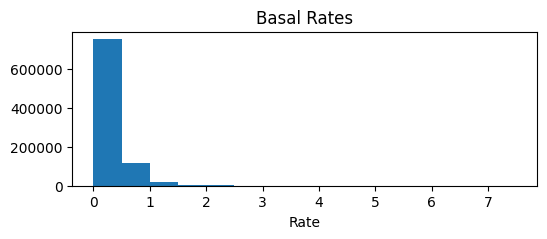

In [12]:
print('Basal Rate info: ')
print(df_basal.BasalRate.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Rate"); plt.title("Basal Rates")
plt.hist(df_basal.BasalRate, bins=np.arange(min(df_basal.BasalRate), max(df_basal.BasalRate) + 0.5, 0.5));

<div class="alert alert-block alert-info"> The maximum basal rate reached ~7.3 U/h.  </div>

### Distribution of Bolus Amounts

Commanded Basal Rate info: 
count    226685.000000
mean          2.140634
std           2.563934
min           0.000000
25%           0.540000
50%           1.215070
75%           2.714080
max          25.000002
Name: BolusAmount, dtype: float64


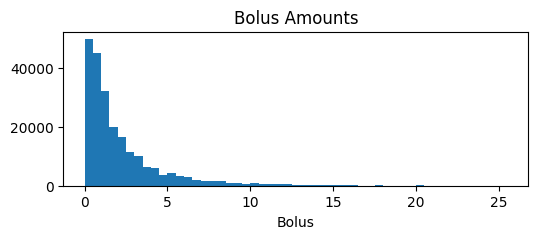

In [13]:
print('Commanded Basal Rate info: ')
print(df_bolus.BolusAmount.describe())

plt.figure(figsize=(6,2)); plt.xlabel("Bolus"); plt.title("Bolus Amounts")
plt.hist(df_bolus.BolusAmount, bins=np.arange(min(df_bolus.BolusAmount), max(df_bolus.BolusAmount) + 0.5, 0.5));